In [ ]:
!wget https://www.eecs.yorku.ca/~bil/Datasets/for-norm.tar.gz

--2023-08-14 16:51:30--  https://www.eecs.yorku.ca/~bil/Datasets/for-norm.tar.gz
Resolving www.eecs.yorku.ca (www.eecs.yorku.ca)... 130.63.94.24
Connecting to www.eecs.yorku.ca (www.eecs.yorku.ca)|130.63.94.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6233933087 (5.8G) [application/x-tar]
Saving to: ‘for-norm.tar.gz’

for-norm.tar.gz     100%[===================>]   5.81G  13.3MB/s    in 7m 32s  

2023-08-14 16:59:04 (13.1 MB/s) - ‘for-norm.tar.gz’ saved [6233933087/6233933087]



In [ ]:
!tar -zxf "/content/for-norm.tar.gz"

## Data Prep

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
DATASET_PATH = '/content/for-norm'

data_dir = pathlib.Path(DATASET_PATH)

train_data_dir = DATASET_PATH + "/training"
val_data_dir = DATASET_PATH + "/validation"

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(train_data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('classes:', commands)

classes: ['real' 'fake']


In [ ]:
train_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    seed=0,
    output_sequence_length=16000,
    )

val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=val_data_dir,
    batch_size=64,
    seed=0,
    output_sequence_length=16000,
    )


label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)


Found 53868 files belonging to 2 classes.
Found 10798 files belonging to 2 classes.

label names: ['fake' 'real']


In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


In [ ]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)


(64, 16000)
(64,)


In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])


In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram


In [ ]:
for i in range(3, 7):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))


Label: real
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: fake
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: real
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: fake
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


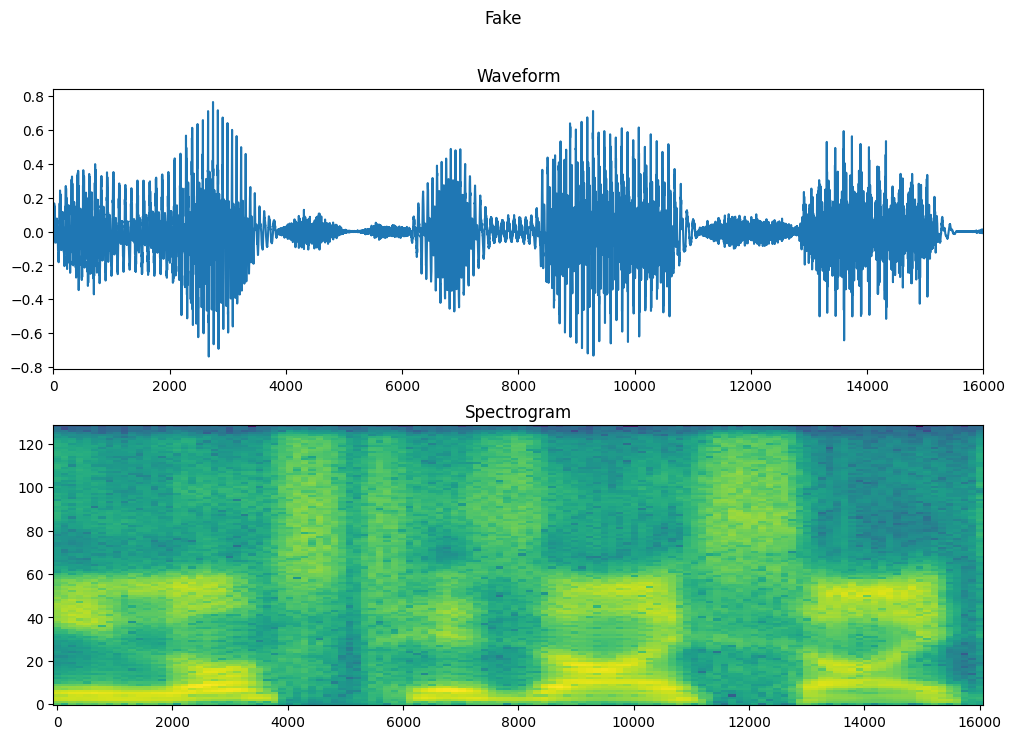

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)


In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


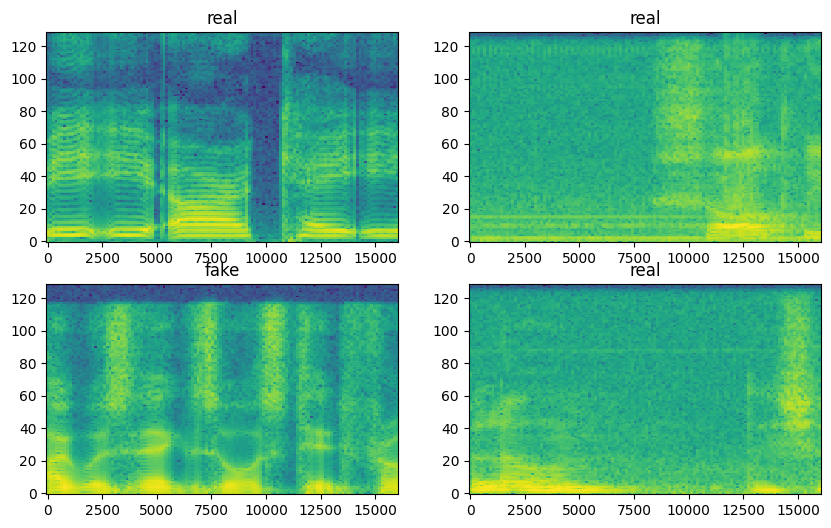

In [ ]:
rows = 2
cols = 2
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()


In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)


# CNN + LSTM

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

In [ ]:
input_shape

In [ ]:
from tensorflow.keras import layers, models

input_shape = (124, 129, 1)  # Adjust this shape based on your input data

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.RepeatVector(28),  # Adjust the number of timesteps based on your data
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(128),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [ ]:
import glob, random

test_dir = (glob.glob('/content/for-norm/testing/*/*.wav'))
random.shuffle(test_dir)
test_dir[:10]

## Inference

In [ ]:
or_l = '/content/for-norm/testing/real/file95.wav_16k.wav_norm.wav_mono.wav_silence.wav'
spl = or_l.split('/')[4]
spl

In [ ]:
for x in test_dir[:5]:
    y_true = x.split('/')[4]
    x = tf.io.read_file(str(x))
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]

    prediction = model(x)
    arg = np.argmax(prediction)
    x_labels = ['fake', 'real']
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.title(f"predicted:{x_labels[arg]} \n true label:{y_true}")
    plt.show()

    display.display(display.Audio(waveform, rate=16000))


# Trans

In [ ]:
%%bash
pip install git+https://github.com/huggingface/transformers.git
pip install datasets
pip install huggingface-hub
pip install joblib
pip install librosa


  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-56mokm3d
  Resolved https://github.com/huggingface/transformers.git to commit c41291965f078070c5c832412f5d4a5f633fcdc4
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.32.0.dev0-py3-none-any.whl size=7459188 sha256=0a346fe89afc4fe6db1c326a4051c690b5441a2f2cc9fee2cdaff3900cd0267c
  Stored in directory: /tmp/pip-ephem-wheel-cache-yfi7s6dd/wh

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-56mokm3d


In [ ]:
import random
import logging

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)
# Set random seed
tf.keras.utils.set_random_seed(42)


In [ ]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 1
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 32  # Batch-size for training and evaluating our model.
NUM_CLASSES = 2  # Number of classes our dataset will have (11 in our case).
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 49
MAX_EPOCHS = 2  # Maximum number of training epochs.

MODEL_CHECKPOINT = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hub


In [ ]:
from datasets import load_dataset

dataset = load_dataset(path="/content/for-norm")

Resolving data files:   0%|          | 0/53868 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/10798 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/4634 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = dataset["train"].train_test_split(
    test_size=0.4, stratify_by_column="label"
)

dataset = dataset.filter(
    lambda x: x["label"]
    != (
        dataset["train"].features["label"]
        and dataset["train"].features["label"]
    )
)

dataset["train"] = dataset["train"].select(
    [i for i in range((len(dataset["train"]) // BATCH_SIZE) * 16)]
)
dataset["test"] = dataset["test"].select(
    [i for i in range((len(dataset["test"]) // BATCH_SIZE) * 16)]
)

print(dataset)


Filter:   0%|          | 0/32320 [00:00<?, ? examples/s]

Filter:   0%|          | 0/21548 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'label'],
        num_rows: 16160
    })
    test: Dataset({
        features: ['audio', 'label'],
        num_rows: 10768
    })
})


In [ ]:
labels = dataset['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

print(id2label)


{'0': 'fake', '1': 'real'}


In [ ]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(
    MODEL_CHECKPOINT, return_attention_mask=True
)


def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding=True,
    )
    return inputs


# This line with pre-process our speech_commands_v1 dataset. We also remove the "audio"
# and "file" columns as they will be of no use to us while training.
processed_dataset = dataset.map(
    preprocess_function, remove_columns=["audio"], batched=True
)

# Load the whole dataset splits as a dict of numpy arrays
train = processed_dataset["train"].shuffle(seed=42).with_format("numpy")[:]
test = processed_dataset["test"].shuffle(seed=42).with_format("numpy")[:]


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Map:   0%|          | 0/16160 [00:00<?, ? examples/s]

Map:   0%|          | 0/10768 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:92: RuntimeWarning: Mean of empty slice.
  normed_slice = (vector - vector[:length].mean()) / np.sqrt(vector[:length].var() + 1e-7)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/feature_extraction_wav2vec2.py:92: RuntimeWarning: Degrees of freedom <= 0 for slice
  normed_slice = (vector - vector[:length].mean()) / np.sqrt(vector[:length].var() + 1e-7)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
from transformers import TFWav2Vec2Model


def mean_pool(hidden_states, feature_lengths):
    attenion_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=tf.dtypes.int64
    )
    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attenion_mask, [-1]), -1), [-1]),
        dtype=tf.dtypes.bool,
    )
    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(~padding_mask, -1), (BATCH_SIZE, MAX_FRAMES, HIDDEN_DIM)
        ),
        0.0,
        hidden_states,
    )
    pooled_state = tf.math.reduce_sum(hidden_states, axis=1) / tf.reshape(
        tf.math.reduce_sum(tf.cast(padding_mask, dtype=tf.dtypes.float32), axis=1),
        [-1, 1],
    )
    return pooled_state


class TFWav2Vec2ForAudioClassification(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        # Instantiate the Wav2Vec 2.0 model without the Classification-Head
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        # Drop-out layer before the final Classification-Head
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        # Classification-Head
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # We take only the first output in the returned dictionary corresponding to the
        # output of the last layer of Wav2vec 2.0
        hidden_states = self.wav2vec2(inputs["input_values"])[0]

        # If attention mask does exist then mean-pool only un-masked output frames
        if tf.is_tensor(inputs["attention_mask"]):
            # Get the length of each audio input by summing up the attention_mask
            # (attention_mask = (BATCH_SIZE x MAX_SEQ_LENGTH) ∈ {1,0})
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            # Get the number of Wav2Vec 2.0 output frames for each corresponding audio input
            # length
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths)
        # If attention mask does not exist then mean-pool only all output frames
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state


In [ ]:
def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    # Compile and return
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model


model = build_model()


/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(



TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['quantizer.codevectors', 'project_hid.bias', 'project_q.weight', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'project_q.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFWav2Vec2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFWav2Vec2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the che

In [ ]:
# Remove targets from training dictionaries
train_x = {x: y for x, y in train.items() if x != "label"}
test_x = {x: y for x, y in test.items() if x != "label"}


In [ ]:
MAX_EPOCHS = 1

In [ ]:
model.fit(
    train_x,
    train["label"],
    validation_data=(test_x, test["label"]),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
)


NameError: ignored

In [ ]:
preds = model.predict(test_x)

In [ ]:
import IPython.display as ipd

rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=True, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])


In [ ]:
rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=True, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])

In [ ]:
rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=True, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])

In [ ]:
rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=True, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])